In [1]:
# simmulate sounds in a grid of parameter values
from __future__ import division
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import spectrogram
import scipy.signal as sg
import socket
import os
import sys
import logging
import h5py
import copy
import glob
import shutil

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
logger.info('Computer: ' + comp_name)

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

if 'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/repos/')
    experiment_folder = os.path.join('/Users/zeke/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'swissknife'))

#setup the data folder
#from h5tools import h5tools
#from h5tools import tables
from swissknife.dynamo import finch as zf
from swissknife.dynamo import takens as tk
from swissknife.bci.core import expstruct as es
from swissknife.bci import synthetic as syn


def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), 
                            scaling='spectrum')
    
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True)
    ax.set_xlim(-before_ms, after_ms + int(x.size/s_f * 1000.))
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

2017-05-12 17:13:55,064 root         INFO     Computer: passaro


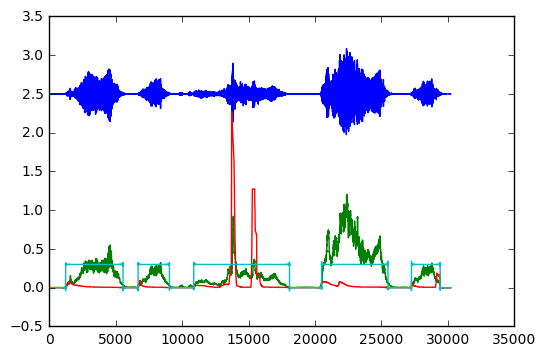

In [6]:
#load values of onof, beta, alpha
bird = 'z007'
bird = 'z007'
sess = 'day-2016-09-10'
syn_sess = 2

fitted_par = syn.load_syn_stream(bird, syn_sess=syn_sess, s_f=30000, new_s_f=44100,  
                                             file_base='synth_bos_export')

# Plot the waveform and the other parameters
plt.plot(fitted_par[:,0]/50000 + 2.5)
onof = fitted_par[:, 1]
beta = fitted_par[:, 2]
alpha = fitted_par[:, 3]
plt.plot(alpha/10)
plt.plot(beta)
plt.plot(onof)

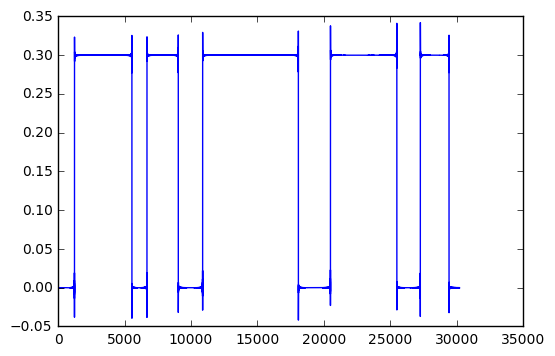

In [7]:
plt.plot(onof)

/mnt/cube/earneodo/repos/swissknife/swissknife/dynamo/finch.py:128: RuntimeWarning: invalid value encountered in sqrt
  pars['A_1'] = np.sqrt(pars['sys']['envelope']) * \


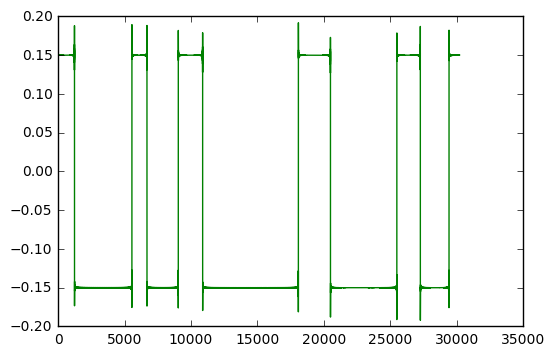

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


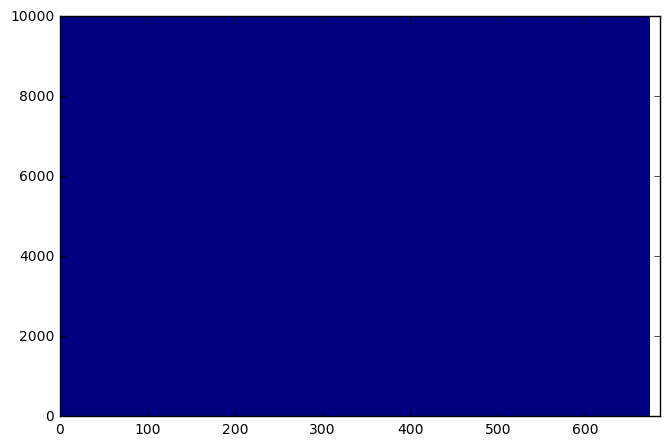

In [8]:
# convert the parameters for the system input and integrate it
# parameters of the vocal organ and the integration of the equations

sys_pars = {'alpha_1': 0.15,
            'beta_1': 0.15,
            'alpha_2': 0.15,
            'beta_2': 0.15,
            'gamma': 23500.,
            'Ch_inv': 4.5E10,
            'Lb_inv': 1.E-4,
            'Lg_inv': 1/82.,
            'Rb': 5E6*10,
            'Rh': 6E5*10,
            'V_ext': 0.,
            'dV_ext': 0.,
            'noise': 0.,
            'envelope': 0.,
            'noise_fraction_beta_1': .1,
            'noise_fraction_env': 0.1,
            's_f': 44100.,
            'steps_per_sample': 20
            }

vocal_pars = {'sys': sys_pars,
              'S_1': 0.2, #0.2
              'S_2': 0.2,
              'S_3': 0.2,
              'l_1': 1.5,
              'l_2': 1.5,
              'l_3': 1.0,
              'r_out': 0.1, #0.1
              'r_12': None,
              'r_21': None,
              'r_23': None,
              'r_32': None,
              't_12': None,
              't_21': None,
              't_23': None,
              't_32': None,
              't_in': 0.5,
              'tau_1': None,
              'tau_2': None,
              'tau_3': None,
              'max_tau': None,
              'A_1': 0.,
              'A_2': None,
              'A_3': None}

reload(syn)
par_stream = syn.fitted_to_stream(onof, beta, alpha)
par_stream[:,2]*=0.001
song_synth = zf.finch(vocal_pars, np.vstack([par_stream[:,0], par_stream[:, 1], par_stream[:, 2]]).T)
plt.plot(song_synth[:, 0])
plt.plot(par_stream[:, 0])
spectr_bos, ax = plot_spectrogram(song_synth[:, 0], 
                                   0, 0, 44100,
                                   n_window = 512, n_overlap=512-1, scaling='spectrum')

In [110]:
from swissknife.bci.core import expstruct as et
from scipy.io import wavfile

fn = et.file_names(bird, 'perturbed')
fold = fn['folders']['stim']

syn_name = 'fit_huge_R'

wav_name = '{}.wav'.format(syn_name)
par_name = '{}_par'.format(syn_name)

save_synth = np.array(song_synth[:, 0]*2000, dtype=np.int16)
wavfile.write(os.path.join(fold, wav_name), sys_pars['s_f'], save_synth)

In [85]:
onof.shape

(13981,)

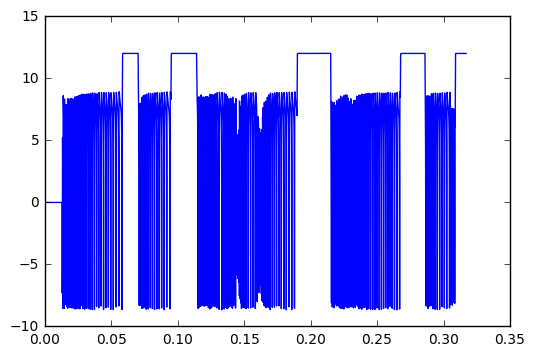

In [81]:
plt.plot(t, song_synth[:, 1])

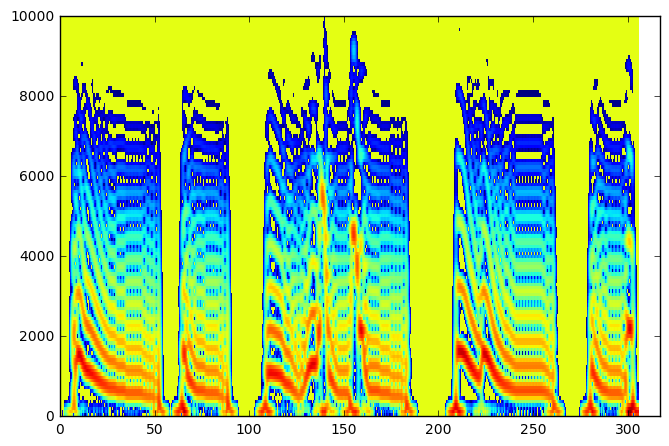

In [47]:
spectr_bos, ax = plot_spectrogram(song_synth[:, 1], 
                                   0, 0, 44100,
                                   n_window = 512, n_overlap=512-1, scaling='spectrum')